In [ ]:
!wget "https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2021/12/DSL2122_january_dataset.zip" 
!unzip '/content/DSL2122_january_dataset.zip' -d '/content'
!pip install nltk
!pip install TextBlob

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text  import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from scipy.sparse import csr_matrix
from textblob import TextBlob
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.svm import SVC  


nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

development = pd.read_csv("/content/DSL2122_january_dataset/development.csv", parse_dates=["date"])
evaluation = pd.read_csv("/content/DSL2122_january_dataset/evaluation.csv", parse_dates=["date"])
development.set_index('ids', drop = False, inplace = True)
df = pd.concat([development, evaluation], sort = False)

#COSTANTS


abbr_dict={
    "what's":"what is",
    "what're":"what are",
    "who's":"who is",
    "who're":"who are",
    "where's":"where is",
    "where're":"where are",
    "when's":"when is",
    "when're":"when are",
    "how's":"how is",
    "how're":"how are",

    "ain't": "be not",
    "aren't": "are not",
    "can't": "cannot",
    "'cause": "because",
    "could've": "could have",

    "i'm":"i am",
    "we're":"we are",
    "you're":"you are",
    "they're":"they are",
    "it's":"it is",
    "he's":"he is",
    "she's":"she is",
    "that's":"that is",
    "there's":"there is",
    "there're":"there are",
    "that're":"that are",
    "this's":"this is",
    "this're":"this are",

    "im":"i am",
    "were":"we are",
    "youre":"you are",
    "theyre":"they are",
    "hes":"he is",
    "shes":"she is",
    "thats":"that is",
    "theres":"there is",

    "dont":"do not",
  
    "ur":"your",
    "aha":"ahah",
    "haha":"ahah",
    "hah":"ahah",
    "thanks":"thank you",
    "u":"you",
    "okay": "ok",
  
    "i've":"i have",
    "we've":"we have",
    "you've":"you have",
    "they've":"they have",
    "who've":"who have",
    "would've":"would have",
    "not've":"not have",

    "i'll":"i will",
    "we'll":"we will",
    "you'll":"you will",
    "he'll":"he will",
    "she'll":"she will",
    "it'll":"it will",
    "they'll":"they will",

    "isn't":"is not",
    "wasn't":"was not",
    "aren't":"are not",
    "weren't":"were not",
    "can't":"can not",
    "couldn't":"could not",
    "don't":"do not",
    "didn't":"did not",
    "shouldn't":"should not",
    "wouldn't":"would not",
    "doesn't":"does not",
    "haven't":"have not",
    "hasn't":"has not",
    "hadn't":"had not",
    "won't":"will not",
    "might've": "might have",
    "mightn't": "might not",
    "y'all": "you all",
    "y'alls": "you alls",
    "gotta": "going to",
    "gonna": "got to",
    "wanna": "want to",
    "wan'na": "want to",
    "lemme": "let me",
    "gimme": "give me",
    "outta": "out of",
    "kinda": "out of",
    "imma": "i am going to",
    "i'mma": "i am going to",
    "hafta": "have to",
    "dunno": "do not",
    "isnt": "is not",
    "arent": "are not",
    "cuz": "because",
}



slang_dict ={ 
  "&LT;3":"heart",
  "&LT;/3":"broken heart",
  "@TEOTD":"At the end of the day",
  ".02":"My two cents worth",
  "1UP":"extra life",
  "121":"private chat",
  "1337":"Leet, 'elite'",
  "143":"I love you",
  "C": "see",
  "CUZ": "Because",
  "1432":"I love you too",
  "14AA41":"One for all, and all for one",
  "182":"I hate you",
  "10X":"Thanks",
  "10Q":"Thank you",
  "1CE":"Once",
  "1DR":"I wonder",
  "1NAM":"One in a million",
  "2B":"To be",
  "2EZ":"Too easy",
  "2G2BT":"Too good to be true",
  "2M2H":"Too much too handle",
  "2MI":"Too much information",
  "2MOR":"Tomorrow",
  "2MORO":"Tomorrow",
  "2M2H":"Too much to handle",
  "2N8":"Tonight",
  "2NTE":"Tonight",
  "4AO":"For adults only",
  "4COL":"For crying out loud",
  "4EAE":"Forever and ever",
  "4EVA":"Forever",
  "4NR":"Foreigner",
  "4SALE":"For sale",
  "6Y":"Sexy",
  "7K":"Sick",
  "A3":"Anytime, anywhere, anyplace",
  "AA":"As above",
  "AAF":"As a matter of fact",
  "AAK":"Asleep at keyboard",
  "AAMOF":"As a matter of fact",
  "AAMOI":"As a matter of interest",
  "AAP":"Always a pleasure",
  "AAR":"At any rate",
  "AAS":"Alive and smiling",
  "AASHTA":"As always, Sheldon has the answer",
  "AATK":"Always at the keyboard",
  "AAYF":"As always, your friend",
  "ABBR":"abbreviation",
  "ABC":"Already been chewed",
  "ABD":"Already been done",
  "ABT":"About",
  "ABT2":"'About to'",
  "ABTA":"Good-bye",
  "ABU":"All bugged up",
  "AC":"Acceptable content",
  "ACC":"Anyone can come",
  "ACD":"ALT / CONTROL / DELETE",
  "ACDNT":"Accident",
  "ACK":"Acknowledge",
  "ACPT":"Accept",
  "ACQSTN":"Acquisition",
  "ADAD":"Another day, another dollar",
  "ADBB":"All done, bye-bye",
  "ADDY":"Address",
  "ADIH":"Another day in hell",
  "ADIP":"Another day in paradise",
  "ADMIN":"Administrator",
  "ADMINR":"Administrator",
  "ADN":"Any day now",
  "ADR":"Address",
  "AEAP":"As early as possible",
  "AF":"April Fools",
  "AFC":"Away from computer",
  "AFAIAA":"As far as I am aware",
  "AFAIC":"As far as I am concerned",
  "AFAIK":"As far as I know",
  "AFAIUI":"As far as I understand it",
  "AFAP":"As far as possible",
  "AFFA":"Angels Forever, Forever Angels",
  "AFJ":"April Fool's joke",
  "AFK":"Away from keyboard",
  "AFZ":"Acronym Free Zone",
  "AFPOE":"A fresh pair of eyes",
  "AIAMU":"And I am a money's uncle",
  "AIGHT":"Alright",
  "AISB":"As it should be",
  "AISB":"As I said before",
  "AISI":"As I see it",
  "AITR":"Adult in the room",
  "AKA":"Also known as",
  "ALCON":"All concerned",
  "ALOL":"Actually laughing out loud",
  "AMA":"Ask me anything",
  "AMAP":"As much as possible",
  "AMBW":"All my best wishes",
  "AML":"All my love",
  "AMOF":"As a matter of fact",
  "A/N":"Author's note",
  "AOC":"Available on cell",
  "AOE":"Area of effect",
  "AOM":"Age of majority",
  "AOTA":"All of the above",
  "AOYP":"Angel on your pillow",
  "APAC":"All praise and credit",
  "AQAP":"As quick as possible",
  "ARC":"compressed files",
  "ARG":"Argument",
  "ASIG":"And so it goes",
  "ASAP":"As soon as possible",
  "A/S/L":"Age/sex/location",
  "ASL":"Age/sex/location",
  "ASLA":"Age/sex/location/availability",
  "ATB":"All the best",
  "ATEOTD":"At the end of the day",
  "ATM":"At the moment",
  "ATSITS":"All the stars in the sky",
  "ATSL":"Along the same line",
  "AWC":"After awhile crocodile",
  "AWESO":"Awesome",
  "AWOL":"Away without leaving",
  "AYDY":"Are you done yet?",
  "AYEC":"At your earliest convenience",
  "AYOR":"At your own risk",
  "AYSOS":"Are you stupid or something?",
  "AYS":"Are you serious?",
  "AYT":"Are you there?",
  "AYTMTB":"And you're telling me this because",
  "AYV":"Are you vertical?",
  "AYW":"As you were",
  "AYW":"As you want",
  "AZN":"Asian",
  "B&amp;":"Banned",
  "B2W":"Back to work",
  "B8":"Bait",
  "B9":"Boss is watching",
  "B/F":"Boyfriend",
  "B/G":"Background",
  "B4":"Before",
  "B4N":"Bye for now",
  "BAG":"Busting a gut",
  "BAE":"Before anyone else",
  "BAE":"Babe or baby",
  "BAFO":"Best and final offer",
  "BAK":"Back at keyboard",
  "BAM":"Below average mentality",
  "BAMF":"Bad ass mother  f ",
  "BAO":"Be aware of",
  "BAS":"Big smile",
  "BASOR":"Breathing a sigh of relief",
  "BAU":"Business as usual",
  "BB":"Be back",
  "BBIAB":"Be back in a bit",
  "BBIAF":"Be back in a few",
  "BBIAM":"Be back in a minute",
  "BBIAS":"Be back in a sec",
  "BBL":"Be back later",
  "BBN":"Bye, bye now",
  "BBS":"Be back soon",
  "BBT":"Be back tomorrow",
  "BC":"Because",
  "B/C":"Because",
  "BC":"Be cool",
  "BCNU":"Be seeing you",
  "BCOS":"Because",
  "BCO":"Big crush on",
  "BCOY":"Big crush on you",
  "BD":"Big deal",
  "BDAY":"Birthday",
  "B-DAY":"Birthday",
  "BDN":"Big darn number",
  "BEG":"Big evil grin",
  "BF":"Brain fart",
  "BFAW":"Best friend at work",
  "BF":"Best friend",
  "BFF":"Best friends forever",
  "BFFL":"Best friends for life",
  "BFFLNMW":"Best friends for life, no matter what",
  "BFD":"Big freaking deal",
  "BFG":"Big freaking grin",
  "BFFN":"Best friend for now",
  "BFN":"Bye for now",
  "BG":"Big grin",
  "BGWM":"Be gentle with me",
  "BHL8":"Be home late",
  "BIB":"Boss is back",
  "BIBO":"Beer in, beer out",
  "BIC":"Butt in chair",
  "BIF":"Before I forget",
  "BIH":"Burn in hell",
  "BIL":"Brother in law",
  "BION":"Believe it or not",
  "BIOYA":"Blow it out your ass",
  "BIOYN":"Blow it out your nose",
  "BITMT":"But in the meantime",
  "BL":"Belly laugh",
  "BLNT":"Better luck next time",
  "BM":"Bite me",
  "BME":"Based on my experience",
  "BM&amp;Y":"Between me and you",
  "BN":"Bad news",
  "BOHICA":"Bend over here it comes again",
  "BOL":"Best of luck",
  "BOLO":"Be on the look out",
  "BOOMS":"Bored out of my skull",
  "BOSMKL":"Bending over smacking my knee laughing",
  "BMS":"Broke my scale, used when rating someone",
  "BOYF":"Boyfriend",
  "BPLM":"Big person little mind",
  "BRB":"Be right back",
  "BR":"Best regards",
  "BRBB":"Be right back  b ",
  "BRNC":"Be right back, nature calls",
  "BRD":"Bored",
  "BRH":"Be right here",
  "BRT":"Be right there",
  "BSF":"But seriously folks",
  "BSOD":"Blue screen of death",
  "BSTS":"Better safe than sorry",
  "BT":"Bite this",
  "BTA":"But then again",
  "BTDT":"Been there, done that",
  "BTW":"By the way",
  "BTYCL":"'Bootycall'",
  "BUBU":"Slang term for the most beautiful of women",
  "BWL":"Bursting with laughter",
  "BYOB":"Bring your own beer",
  "BYOC":"Bring your own computer",
  "BYOD":"Bring your own device",
  "BYOH":"Bat you on the head",
  "BYOP":"Bring your own paint",
  "BYTM":"Better you than me",
  "C&AMP;G":"Chuckle and grin",
  "C4N":"Good bye for now",
  "CAD":"Control + Alt + Delete",
  "CAKEDAY":"Birthday",
  "CB":"Coffee break",
  "CD9":"Code 9, parents are around",
  "CFS":"Care for secret?",
  "CFY":"Calling for you",
  "CHK":"Check",
  "CICO":"Coffee in, coffee out",
  "CID":"Crying in disgrace",
  "CLAB":"Crying like a baby",
  "CLD":"Could",
  "CLK":"Click",
  "CM":"Call me",
  "CMB":"Call me back",
  "CMGR":"Community manager",
  "CMIIW":"Correct me if I am wrong",
  "CMON":"Come on",
  "CNP":"Continued next post",
  "COB":"Close of business",
  "COH":"City of Heroes",
  "COS":"Because",
  "C/P":"Cross post",
  "CP":"Chat post",
  "CR8":"Create",
  "CRE8":"Create",
  "CRA CRA":"Slang term crazy",
  "CRB":"Come right back",
  "CRBT":"Crying really big tears",
  "CRZ":"Crazy",
  "CRS":"Can't remember  stuff ",
  "CSG":"Chuckle, snicker, grin",
  "CSL":"Can't stop laughing",
  "CT":"Can't talk",
  "CTC":"Care to chat?",
  "CTHU":"Cracking the  heck  up",
  "CTN":"Can't talk now",
  "CTO":"Check this out",
  "CU":"See you",
  "CU2":"See you",
  "CUA":"See you around",
  "CUL":"See you later",
  "CULA":"See you later alligator",
  "CUL8R":"See you later",
  "CUMID":"See you in my dreams",
  "CURLO":"See you around like a donut",
  "CWD":"Comment when done",
  "CWOT":"Complete waste of time",
  "CWYL":"Chat with you later",
  "CX":"Correction",
  "CYA":"See you",
  "CYAL8R":"See you later",
  "CYE":"Check your e-mail",
  "CYO":"See you online",
  "D46?":"Down for sex?",
  "DA":"The",
  "DAE":"Does anyone else?",
  "DAFUQ":"What the  Freak ?",
  "DAM":"Don't annoy me",
  "DBAU":"Doing business as usual",
  "DBEYR":"Don't believe everything you read",
  "DC":"Disconnect",
  "DDG":"Drop dead gorgeous",
  "DEEZ NUTZ":"frustate",
  "DEGT":"Dear  daughter",
  "DERP":"stupid or silly",
  "DF":"Don't even go there",
  "DGA":"Don't go anywhere",
  "DGAF":"Don't give a  freak ",
  "DGT":"Don't go there",
  "DGTG":"Don't go there, girlfriend",
  "DGYF":"Dang, girl you fine",
  "DH":"Dear  husband",
  "DHU":"hugs",
  "DIIK":"Darned if I know",
  "DIKU":"Do I know you?",
  "DILLIGAF":"Do I look like I give a  freak?",
  "DILLIGAS":"Do I look like I give a sugar?",
  "DIS":"Did I say?",
  "DITYID":"Did I tell you I'm distressed?",
  "DIY":"Do it yourself",
  "DKDC":"Don't know, don't care",
  "D/L":"Download",
  "DL":"Download",
  "DLBBB":"Don't let the bed bugs bite",
  "DLTBBB":"Don't let the bed bugs bite",
  "DM":"Direct message",
  "DMNO":"Dude Man No Offense",
  "DMY":"Don't mess yourself",
  "DN":"Down",
  "DNC":"I do not understand",
  "DNR":"Dinner",
  "DNT":"Don't",
  "D00D":"Dude",
  "DORBS":"Adorable",
  "DOWNVOTE":"Voting negatively",
  "DQMOT":"Don't quote me on this",
  "DR":"Didn't read",
  "DS":"Dear  son",
  "DTR":"Define the relationship",
  "DTRT":"Do the right thing",
  "DTS":"Don't think so",
  "DTTD":"Don't touch that dial",
  "DUPE":"Duplicate",
  "DUR":"Do you remember?",
  "DV8":"Deviate",
  "DW":"Dear  wife",
  "DWF":"Divorced white female",
  "DWM":"Divorced white male",
  "DXNRY":"Dictionary",
  "DYNWUTB":"Do you know what you are talking about?",
  "DYFI":"Did you find it?",
  "DYFM":"Dude, you fascinate me",
  "DYJHIW":"Don't you just hate it when?",
  "DYOR":"Do your own research",
  "E1":"Everyone",
  "E123":"Easy as one, two, three",
  "E2EG":"Ear to ear grin",
  "EAK":"Eating at keyboard",
  "EBKAC":"Error between keyboard and chair",
  "ED":"Erase display",
  "EF4T":"Effort",
  "EG":"Evil grin",
  "EI":"Eat it",
  "EIP":"Editing in progress",
  "ELI5":"Explain like I'm 5",
  "EM":"E-mail",
  "EMA":"E-mail address",
  "EMBAR":"Embarassing",
  "EMFBI":"Excuse me for butting in",
  "EMFBI":"Excuse me for jumping in",
  "EMSG":"E-mail message",
  "ENUF":"Enough",
  "EOD":"End of day",
  "EOL":"End of life",
  "EOM":"End of message",
  "EOS":"End of show",
  "EOT":"End of transmission",
  "ES":"Erase screen",
  "ESAD":"Eat  S  and die!",
  "ETA":"Estimated time of arrival",
  "EVA":"Ever",
  "EVO":"Evolution",
  "EWG":"Evil wicked grin",
  "EWI":"Emailing while intoxicated",
  "EXTRA":"over the top",
  "EYC":"Excitable, yet calm",
  "EZ":"Easy",
  "EZY":"Easy",
  "F2F":"Face to face",
  "FAAK":"Falling asleep at keyboard",
  "FAB":"Fabulous",
  "FACEPALM":"frustration",
  "FAF":"Funny as  freak ",
  "FAM":"Family",
  "FAQ":"Frequently asked questions",
  "FAY":"Freak  all you",
  "FB":"Facebook",
  "FBB":"Facebook buddy",
  "FBC":"Facebook chat",
  "FBF":"Facebook friend",
  "FBFR":"FaceBook friend",
  "FBM":"Fine by me",
  "FBO":"Facebook official",
  "FBOW":"For better or worse",
  "FC":"Fingers crossed",
  "FC'INGO":"For crying out loud",
  "FCOL":"For crying out loud",
  "FEELSBADMAN":"feel negative.",
  "FEELSGOODMAN":"feel positive.",
  "FEITCTAJ":" Freak  'em if they can't take a joke",
  "FF":"Follow Friday",
  "FFS":"For  freak' sakes",
  "FICCL":"Frankly I couldn't care a less",
  "FIF":" Freak  I'm funny",
  "FIIK":" Freaked  if I know",
  "FIIOOH":"Forget it, I'm out of here",
  "FIL":"Father in law",
  "FIMH":"Forever in my heart",
  "Finna":"Means Going to",
  "FISH":"First in, still here",
  "FITB":"Fill in the blank",
  "FML":" Freak  My Life",
  "FOMC":"Falling off my chair",
  "FOMO":"Fear of missing out",
  "FOAD":" Freak  off and die",
  "FOAF":"Friend of a friend",
  "FOMCL":"Falling off my chair laughing",
  "FRT":"For real though",
  "FTBOMH":"From the bottom of my heart",
  "FTFY":"Fixed that for you",
  "FTL":"For the loss",
  "FTW":"For the win",
  "FU":" Freak  you",
  "FUBAR":"Fouled up beyond all recognition",
  "FUBB":"Fouled up beyond belief",
  "FUTAB":"Feet up, take a break",
  "FW":"Forward",
  "FWB":"Friend with benefits",
  "FWIW":"For what it's worth",
  "FWM":"Fine with me",
  "FWP":"First world problems",
  "FYE":"Fire, something that is cool",
  "FYEO":"For your eyes only",
  "FYA":"For your amusement",
  "FYI":"For your information",
  "G":"Grin",
  "G/F":"Girlfriend",
  "G2CU":"Good to see you",
  "G2G":"Got to go",
  "G2GICYAL8ER":"Got to go I'll see you later",
  "G2R":"Got to run",
  "G2TU":"Got to tell you",
  "G4C":"Going for coffee",
  "G9":"Genius",
  "GA":"Go ahead",
  "GAC":"Get a clue",
  "GAFC":"Get a  freaking  clue",
  "GAL":"Get a life",
  "GAS":"Got a second?",
  "GB":"Goodbye",
  "GBTW":"Get back to work",
  "GBU":"God bless you",
  "GD":"Good",
  "GDR":"Grinning, ducking, and running",
  "GD/R":"Grinning, ducking, and running",
  "GFI":"Go for it",
  "GF":"Girl friend",
  "GFN":"Gone for now",
  "GG":"Have got to Go",
  "GGU2":"Good game, you too",
  "GGMSOT":"Have got to get me some of that",
  "GGOH":"Have got to Get Outa Here",
  "GGP":"Got to go pee",
  "GIAR":"Give it a rest",
  "GIGO":"Garbage in, garbage out",
  "GIRL":"Guy in real life",
  "GJ":"Good job",
  "GL":"Good luck",
  "GMBA":"Giggling my butt off",
  "GMTA":"Great minds think alike",
  "GMV":"Got my vote",
  "GN":"Good night",
  "GNA":"Good night all",
  "GNE1":"Good night everyone",
  "GNIGHT":"Good night",
  "GNITE":"Good night",
  "GNSD":"Good night, sweet dreams",
  "GOAT":"Greatest of all Time",
  "GOI":"Get over it",
  "GOL":"Giggling out loud",
  "GOMB":"Get off my back",
  "GPOY":"Gratuitous picture of yourself",
  "GR8":"Great",
  "GRATZ":"Congratulations",
  "GRL":"Girl",
  "GRWG":"Get right with God",
  "GR&amp;D":"Grinning, running and ducking",
  "GS":"Good shot",
  "GT":"Good try",
  "GTFO":"Get the  freak  out",
  "GTFOH":"Get the  freak  outta here",
  "GTM":"Giggling to myself",
  "GTRM":"Going to read mail",
  "GTSY":"Great to see you",
  "GUCCI":"Good",
  "GUD":"Good",
  "GWHTLC":"Glad we had this little chat",
  "H":"Hug",
  "H8":"Hate",
  "H8TTU":"Hate to be you",
  "HAG1":"Have a good one",
  "HAK":"Hug and kiss",
  "HAU":"How about you?",
  "H&amp;K":"Hugs and kisses",
  "H2CUS":"Hope to see you soon",
  "HAGN":"Have a good night",
  "HAGO":"Have a good one",
  "HAND":"Have a nice day",
  "HAWT":"Have a wonderful day",
  "HAWT":"sexy or attractive",
  "HB":"Hurry back",
  "HBD":"Happy birthday",
  "H-BDAY":"Happy Birthday",
  "HBU":"How about you?",
  "HF":"Have fun",
  "HFAC":"Holy flipping animal crackers",
  "H-FDAY":"Happy Father's Day",
  "H-MDAY":"Happy Mother's Day",
  "HMU":"Hit me up",
  "HNL":"(w)Hole 'nother level",
  "HOAS":"Hold on a second",
  "HRU":"How are you?",
  "HTH":"Hope this helps",
  "HUB":"Head up butt",
  "HUYA":"Head up your  butt ",
  "HV":"Have",
  "HW":"Homework",
  "HYFR":"Hell yeah,  Freaking  right!",
  "I2":"I too",
  "IA8":"I already ate",
  "IAAA":"I am an accountant",
  "IAAD":"I am a doctor",
  "IAAL":"I am a lawyer",
  "IAC":"In any case",
  "IAE":"In any event",
  "IANAC":"I am not a crook",
  "IANAL":"I am not a lawyer",
  "IAO":"I am out ",
  "IB":"I'm back",
  "IC":"I see",
  "ICAM":"I couldn't agree more",
  "ICBW":"It could be worse",
  "ICEDI":"I can't even discuss it",
  "ICFILWU":"I could fall in love with you",
  "ICYMI":"In case you missed it ",
  "IDBI":"I don't believe it",
  "IDC":"I don't care",
  "IDGAF":"I don't give a  freak ",
  "IDK":"I don't know",
  "IDTS":"I don't think so",
  "IDUNNO":"I don't know",
  "IFYP":"I feel your pain",
  "IG":"Instagram",
  "IG2R":"I got to run",
  "IGHT":"I got high tonight",
  "IGN":"I (I've) got nothing",
  "IGP":"I got to (go) pee",
  "IHNI":"I have no idea",
  "IIRC":"If I remember correctly",
  "IIIO":"Intel inside, idiot outside",
  "IK":"I know",
  "IKR":"I know, right?",
  "ILBL8":"I'll be late",
  "ILU":"I love you",
  "ILUM":"I love you man",
  "ILYSM":"I love you so much",
  "ILY":"I love you",
  "IMAO":"In my arrogant opinion",
  "IMHO":"In my humble opinion",
  "IML":"I love you",
  "IMNSHO":"In my not so humble opinion",
  "IMO":"In my opinion",
  "IMS":"I am sorry",
  "IMSB":"I am so bored",
  "IMTM":"I am the man",
  "IMU":"I miss u (you)",
  "INAL":"I'm not a lawyer",
  "INSPOO":"Inspiration",
  "INV":"Invite",
  "IOMH":"In over my head",
  "IOW":"In other words",
  "IRL":"In real life",
  "IRMC":"I rest my case",
  "ISLY":"I still love you",
  "ISO":"In search of",
  "ITT":"In This Thread",
  "ITYK":"I thought you knew",
  "IUSS":"If you say so",
  "IWALU":"I will always love you",
  "IWAWO":"I want a way out",
  "IWIAM":"Idiot wrapped in a moron",
  "IWSN":"I want sex now",
  "IYKWIM":"If you know what I mean",
  "IYO":"In your opinion",
  "IYQ":"I like you",
  "IYSS":"If you say so",
  "J00":"You",
  "J00R":"Your",
  "JAC":"Just a second",
  "JAM":"Just a minute",
  "JAS":"Just a second",
  "JC":"Just checking",
  "JDI":"Just do it",
  "JELLY":"jealous",
  "JFF":"Just for fun",
  "JFGI":"Just  freaking Google it",
  "JIC":"Just in case",
  "JJ":"Just joking",
  "JJA":"Just joking around",
  "JK":"Just kidding",
  "JLMK":"Just let me know",
  "JMO":"Just my opinion",
  "JP":"Just playing",
  "JT":"Just teasing",
  "JTLYK":"Just to let you know",
  "JV":"Joint venture",
  "JW":"Just wondering",
  "K":"Okay",
  "KK":"Knock, knock",
  "KK":"Okay, Okay!",
  "K8T":"Katie",
  "K/B":"Keyboard",
  "KB":"Keyboard",
  "KDFU":"Means Cracking the  freak  up",
  "KEWL":"Cool",
  "KEYA":"I will key you later",
  "KEYME":"Key me when you get in",
  "KFY":"Kiss for you",
  "KIA":"Know it all",
  "KIR":"Keep it real",
  "KISS":"Keep it simple, stupid",
  "KIT":"Keep in touch",
  "KMA":"Kiss my ass",
  "KMK":"Kiss my keister",
  "KMS":"Killing myself",
  "KMT":"Kiss my tushie",
  "KOC":"Kiss on cheek",
  "KOL":"Key opinion leader",
  "KOREABOO":"Someone obsessed with Korean culture",
  "KOS":"Kid over shoulder",
  "KOW":"Knock on wood",
  "KOTC":"Kiss on the cheek",
  "KOTL":"Kiss on the lips",
  "KNIM":"Know what I mean?",
  "KPC":"Keeping parents clueless",
  "KSC":"Kind sort chuckle",
  "KT":"Katie",
  "KUTGW":"Keep up the good work",
  "KYS":"Kill yourself",
  "L2G":"Like to go?",
  "L2K":"Like to come",
  "L2P":"Learn to play",
  "l33t":"Leet, 'elite'",
  "L4L":"Like for like",
  "L8R":"Later",
  "L8RG8R":"Later, gator",
  "LBAY":"Laughing back at you",
  "LBS":"Laughing, but serious",
  "LBVS":"Laughing, but very serious",
  "LD":"Later, dude",
  "LD":"Long distance",
  "LDO":"Like, duh obviously",
  "LEMENO":"Let me know",
  "LERK":"Leaving easy reach of keyboard",
  "LFD":"Left for day",
  "LGH":"Lets get high",
  "LH6":"Lets have sex",
  "LHSX":"Lets have sex",
  "LHM":"Lord help me",
  "LHO":"Laughing head off",
  "LI":"LinkedIn",
  "LIC":"Like I care",
  "LIK":"liquor",
  "LIMT":"Laugh in my tummy",
  "LLGB":"Love, later, God bless",
  "LLS":"Laughing like  silly ",
  "LMAO":"Laughing my ass off",
  "LMBO":"Laughing my butt off",
  "LMFAO":"Laughing my freaking ass off",
  "LMIRL":"Lets meet in real life",
  "LMK":"Let me know",
  "LMMFAO":"Laughing my mother freaking ass off",
  "LMNK":"Leave my name out",
  "LNT":"lost in translation",
  "LOA":"List of acronyms",
  "LOLH":"Lol a lot",
  "LOLO":"Lots of love",
  "LOLWTF":" What the  freak ?",
  "LOTI":"Laughing on the inside",
  "LQTM":"Laughing quietly to myself",
  "LSHMBH":"Laugh so hard my belly hurts",
  "LSV":"Language, sex and violence",
  "LTD":"Living the dream",
  "LTLWDLS":"Let's twist like we did last summer",
  "LTNS":"Long time no see",
  "LTOD":"Laptop of death",
  "LTS":"Laughing to self",
  "LULT":"Love you long time",
  "LULZ":"joke, or for laughs",
  "LVM":"Left voice mail",
  "LWOS":"Laughing without smiling",
  "LY":"Love you",
  "LYLAS":"Love you like a sis",
  "LYLC":"Love you like crazy",
  "LYSM":"Love you so much",
  "M$":"Microsoft",
  "M8":"Mate",
  "MB":"Mamma's boy",
  "MBS":"Mom behind shoulder",
  "MC":"Merry Christmas",
  "MDIAC":"My Dad is a cop",
  "MEGO":"My eyes glaze over",
  "MEH":"a shrug or shrugging shoulders",
  "MEH":"a so-so or just okay",
  "MEHH":"a sigh or sighing",
  "MFI":"Mad for it",
  "MFW":"My face when",
  "MGB":"May God bless",
  "MGMT":"Management",
  "MHOTY":"My hat is off to you",
  "MIRL":"Me in real life",
  "MIRL":"Meet in real life",
  "MKAY":"Mmm, okay",
  "MLM":"give the middle finger",
  "MNC":"Mother nature calls",
  "MOD":"Moderator",
  "MORF":"Male or female?",
  "MOMBOY":"Mamma's boy",
  "MOO":"My own opinion",
  "MOOS":"Member of the opposite sex",
  "MOS":"Mother over shoulder",
  "MOSS":"Member of same sex",
  "MRT":"Modified ReTweet",
  "MRW":"My reaction when",
  "MSG":"Message",
  "MTF":"More to follow",
  "MTFBWU":"May the force be with you",
  "MU":"Miss you",
  "MUAH":"Multiple unsuccessful attempts at humor",
  "MUSM":"Miss you so much",
  "MWAH":"kiss",
  "MYOB":"Mind your own business",
  "N00B":"Newbie",
  "N1":"Nice one",
  "N2M":"Nothing too much",
  "NADT":"Not a darn thing",
  "NALOPKT":"Not a lot of people know that",
  "NANA":"Not now, no need",
  "NBD":"No big deal",
  "NE":"Any",
  "NE1":"Anyone",
  "NFM":" Not for me",
  "NFM":"Not for me",
  "NGL":"Not going to lie",
  "NFS":"Not for sale",
  "NFW":"No  freaking  way",
  "NFW":"Not for work",
  "NFWS":"Not for work safe",
  "NIFOC":"Naked in front of computer",
  "NIGI":"Now I get it",
  "NIMBY":"Not in my back yard",
  "NIROK":"Not in reach of keyboard",
  "NLT":"No later than",
  "NM":"Nothing much",
  "NM":"Never mind",
  "NMH":"Not much here",
  "NMJC":"Nothing much, just chilling",
  "NMU":"Not much, you?",
  "NO1":"No one",
  "NOOB":"someone who is bad at games",
  "NOWL":"knowledge",
  "NOYB":"None of your business",
  "NP":"No problem",
  "NQT":"Newly qualified teacher",
  "NRN":"No response/reply necessary",
  "NSA":"No strings attached",
  "NSFL":"Not safe for life",
  "NSFW":"Not safe for work",
  "NSISR":"Not sure if spelled right",
  "NT":"Nice try",
  "NTHING":"Nothing",
  "NTS":"Note to self",
  "NVM":"Never mind",
  "NVR":"Never",
  "NW":"No way",
  "NWO":"No way out",
  "O4U":"Only for you",
  "OATUS":"On a totally unrelated subject",
  "OB":"Oh baby",
  "OBV":"Obviously",
  "OFC":"Of course",
  "OG":"Original gangster",
  "OGIM":"Oh God, it's Monday",
  "OHHEMMGEE":"Oh My God",
  "OI":"Operator indisposed",
  "OIB":"Oh, I'm back",
  "OIC":"Oh, I see",
  "OJ":"Only joking",
  "OL":"Old lady",
  "OLL":"Online love",
  "OM":"Oh, my",
  "OMAA":"Oh, my aching ass",
  "OMDB":"Over my dead body",
  "OMFG":"Oh my  freaking  God",
  "OMG":"Oh my God",
  "OMGYG2BK":"Oh my God, you got to be kidding",
  "OMGYS":"Oh my gosh you suck",
  "OMS":"On my soul",
  "OMW":"On my way",
  "ONL":"Online",
  "OOC":"Out of character",
  "OOMF":"One of my followers",
  "OOTD":"One of these days",
  "OOTD":"Outfit of the day",
  "OOTO":"Out of the office",
  "OP":"On phone",
  "ORLY":"Oh really?",
  "OT":"Off topic",
  "OTB":"Off to bed",
  "OTFL":"On the floor laughing",
  "OTL":"Out to lunch",
  "OTOH":"On the other hand",
  "OTP":"On the phone",
  "OTP":"One true pairing; two people you would love to see as a couple",
  "OTT":"Over the top",
  "OTTOMH":"Off the top of my head",
  "OTW":"Off to work",
  "OVA":"Over",
  "OYO":"On your own",
  "P2P":"Peer to peer",
  "P911":"Parents coming into room alert",
  "PAP":"Post a picture",
  "PAW":"Parents are watching",
  "PBOOK":"Phonebook",
  "PCM":"Please call me",
  "PDA":"Personal display of affection",
  "PDH":"Pretty darn happy",
  "PDS":"Please don't shoot",
  "PDQ":"Pretty darn quick",
  "PEEPS":"People",
  "PFT":"Pretty  freaking  tight",
  "PIC":"Picture",
  "PIP":"lauthing",
  "PIR":"Parents in room",
  "PISS":"Put in some sugar",
  "PITA":"Pain in the  butt ",
  "PL8":"Plate",
  "PLD":"Played",
  "PLMK":"Please let me know",
  "PLS":"Please",
  "PLU":"People like us",
  "PLZ":"Please",
  "PLZTLME":"Please tell me",
  "PM":"Private Message",
  "PMFI":"Pardon me for interrupting",
  "PMFJI":"Pardon me for jumping in",
  "PMSL":"Pee myself laughing",
  "POAHF":"Put on a happy face",
  "POIDH":"Picture, or it didn't happen",
  "POS":"Parent over shoulder",
  "POTD":"Photo of the day",
  "POV":"Point of view",
  "PPL":"People",
  "PPU":"Pending pick-up",
  "PRESH":"Precious",
  "PROBS":"Probably",
  "PROLLY":"Probably",
  "PROGGY":"computer program",
  "PRON":"pornography",
  "PRT":"Please retweet",
  "PRW":"People/parents are watching",
  "PSA":"Public Service Announcement",
  "PSOS":"Parent standing over shoulder",
  "PSP":"Playstation Portable",
  "PTFO":"Pass the  freak  out",
  "PTIYPASI":"Put that in your pipe and smoke it",
  "PTL":"Praise the Lord",
  "PTMM":"Please tell me more",
  "PTO":"Paid time off",
  "PWN":"own",
  "PXT":"Please explain that",
  "PU":"That stinks!",
  "PUKS":"Pick up kids (SMS)",
  "PYT":"Pretty young thing",
  "PZ":"Peace",
  "PZA":"Pizza",
  "Q":"Queue",
  "Q4U":"I have a question for you",
  "QC":"Quality control",
  "QFE":"Question for everyone",
  "QFI":"Quoted for idiocy",
  "QFI":"Quoted for irony",
  "QFT":"Quoted for truth",
  "QIK":"Quick",
  "QL":"Quit laughing",
  "QOTD":"Quote of the day",
  "QSL":"Reply",
  "QSO":"Conversation",
  "QT":"Cutie",
  "QTPI":"Cutie pie",
  "R":"are",
  "R8":"Rate",
  "RBAY":"Right back at you",
  "RFN":"Right  freaking  now",
  "RGR":"I agree",
  "RHIP":"Rank has its privileges",
  "RIP":"Rest in peace",
  "RL":"Real life",
  "RLY":"Really",
  "RME":"Rolling my eyes",
  "RMLB":"Read my lips baby",
  "RMMM":"Read my mail man",
  "ROFL":"Rolling on floor laughing",
  "ROFLCOPTER":"Rolling on floor laughing and spinning around",
  "ROFLMAO":"Rolling on the floor, laughing my  butt  off",
  "ROTFL":"Rolling on the floor laughing",
  "ROTFLUTS":"Rolling on the floor laughing unable to speak",
  "RSN":"Real soon now",
  "RT":"Retweet",
  "RTBS":"Reason to be single",
  "RTFM":"Read the  freaking  manual",
  "RTFQ":"Read the  freaking  question",
  "RTHX":"Thanks for the Retweet",
  "RTMS":"Read the manual, stupid",
  "RTSM":"Read the stupid manual",
  "RTWFQ":"Read the whole  freaking  question",
  "RU":"Are you?",
  "RUMOF":"Are you male or female?",
  "RUT":"Are you there?",
  "RUOK":"Are you okay?",
  "RX":"Regards",
  "RW":"Real world",
  "RX":"drugs or prescriptions",
  "RYB":"Read your Bible",
  "RYO":"Roll your own",
  "RYS":"Read your screen",
  "RYS":"Are you single?",
  "S2R":"Send to receive",
  "S2S":"Sorry to say",
  "S4L":"Spam for life",
  "SAL":"Such a laugh",
  "SAT":"Sorry about that",
  "SB":"Should be",
  "SBIA":"Standing back in amazement",
  "SBT":"Sorry 'bout that",
  "SC":"Stay cool",
  "SD":"Sweet dreams",
  "SDMB":"Sweet dreams, my baby",
  "SENPAI":"someone older than you, someone you look up to",
  "SEO":"Search engine optimization",
  "SETE":"Smiling Ear-to-Ear",
  "SFAIK":"So far as I know",
  "SH":"Same here",
  "SH^":"Shut up",
  "SHID":"Slapping head in disgust",
  "SICNR":"Sorry, I could not resist",
  "SIG2R":"Sorry, I got to run",
  "SIHTH":"Stupidity is hard to take",
  "SIMYC":"Sorry I missed your call",
  "SIS":"sister",
  "SITD":"Still in the dark",
  "SJW":"Social justice warrior",
  "SK8":"Skate",
  "SK8NG":"Skating",
  "SK8R":"Skater",
  "SK8RBOI":"Skater Boy",
  "SM":"Social media",
  "SMAZED":"Smoky haze",
  "SMEXI":"sexy",
  "SMH":"Shaking my head",
  "SMHID":"Scratching my head in disbelief",
  "SNAFU":"Situation normal all fouled up",
  "SNERT":"Snot nosed egotistical rude teenager",
  "SNR":"Streaks and Recents",
  "SOAB":"Son of a  Bitch ",
  "S'OK":"It's okay ",
  "SOL":"Sooner or later",
  "SOMY":"Sick of me yet?",
  "SORG":"Straight or Gay?",
  "SOS":"help",
  "SOT":"Short of time",
  "SOTMG":"Short of time, must go",
  "SOWM":"Someone with me",
  "SPK":"Speak",
  "SRSLY":"Seriously",
  "SPST":"Same place, same time",
  "SPTO":"Spoke to",
  "SQ":"Square",
  "SRY":"Sorry",
  "SS":"So sorry",
  "SSDD":"Same stuff, different day",
  "SSIF":"So stupid it's funny",
  "SSINF":"So stupid it's not funny",
  "ST&amp;D":"Stop texting and drive",
  "STFU":"Shut the  freak  up",
  "STR8":"Straight",
  "STW":"Search the Web",
  "SU":"Shut up",
  "SUITM":"See you in the morning",
  "SUL":"See you later",
  "SUP":"What's up?",
  "SUX":" sucks or it sucks",
  "SUYF":"Shut up you fool",
  "SWAK":"Sent (or sealed) with a kiss",
  "SWALK":"Sealed (or sealed) with a loving kiss",
  "SWAT":"Scientific wild  butt  guess",
  "SWL":"Screaming with laughter",
  "SWMBO":"She who must be obeyed. wife or partner",
  "SYL":"See you later",
  "SYS":"See you soon",
  "SYY":"Shut your yapper",
  "T+":"Think positive",
  "T4BU":"Thanks for being you",
  "T:)T":"Think happy thoughts",
  "TA":"Thanks a lot",
  "TAFN":"That's all for now",
  "TAM":"Tomorro a.m.",
  "TANK":"really strong",
  "TANKED":"owned",
  "TANKING":"owning",
  "TARFU":"Things Are Really  fouled  Up.",
  "TAU":"Thinking about you",
  "TAUMUALU":"Thinking about you miss you always love you",
  "TBBH":"To be brutally honest",
  "TBC":"To be continued",
  "TBD":"To be determined",
  "TBH":"To be honest",
  "TBL":"Text back later",
  "TBT":"Throwback Thursday",
  "TC":"Take care",
  "TCB":"Take care of business",
  "TCOY":"Take care of yourself",
  "TD2M":"Talk dirty to me",
  "TDTM":"Talk dirty to me",
  "TFF":"Too freaking  funny",
  "TFS":"Thanks for sharing",
  "TFTF":"Thanks for the follow",
  "TFTI":"Thanks for the invitation",
  "TFTT":"Thanks for this tweet",
  "TG":"Thank goodness",
  "TGIF":"Thank God it's Friday",
  "THNQ":"Thank you",
  "THNX":"Thanks",
  "THOT":"That wh re over there",
  "THT":"Think happy thoughts",
  "THX":"Thanks",
  "TIA":"Thanks in advance",
  "TIAD":"Tomorrow is another day",
  "TIC":"Tongue-in-cheek",
  "TIL":"Today I learned",
  "TILIS":"Tell it like it is",
  "TIR":"Teacher in room",
  "TLK2UL8R":"Talk to you later",
  "TL":"Too long",
  "TL;DR":"Too long; didn't read",
  "TM":"Trust me",
  "TMA":"Take my advice",
  "TMB":"Text me back",
  "TMB":"Tweet me back",
  "TMI":"Too much information",
  "TMOT":"Trust me on this",
  "TMTH":"Too much to handle",
  "TMYL":"Tell me your location",
  "TMWFI":"Take my word for it",
  "TNSTAAFL":"There's no such thing as a free lunch",
  "TNT":"Til next time",
  "TOJ":"Tears of joy",
  "TOS":"Terms of service",
  "TOTES":"Totally",
  "TOU":"Thinking of you",
  "TOY":"Thinking of you",
  "TPM":"Tomorrow p.m.",
  "TPTB":"The powers that be",
  "TSH":"Tripping so hard",
  "TSNF":"That's so not fair",
  "TSTB":"The sooner, the better",
  "TT":"Trending topic",
  "TTFN":"Ta ta for now",
  "TTLY":"Totally",
  "TTTT":"These things take time",
  "TTUL":"Talk to you later",
  "TU":"Thank you",
  "TMRW":"Tomorrow",
  "TUI":"Turning you in",
  "TURNT":"excitement, turned up",
  "TWSS":"That's what she said",
  "TTG":"Time to go",
  "TTYAFN":"Talk to you awhile from now",
  "TTYL":"Talk to you later",
  "TTYS":"Talk to you soon",
  "TY":"Thank you",
  "TYFYC":"Thank you for your comment",
  "TYS":"Told you so",
  "TYT":"Take your time",
  "TYSO":"Thank you so much",
  "TYAFY":"Thank you and  freak  you",
  "TYVM":"Thank you very much",
  "TX":"Thanks",
  "^URS":"Up yours",
  "UCMU":"You crack me up",
  "UDM":"You the man",
  "UDS":"Ugly domestic scene",
  "UFB":"Un  freaking  believable",
  "UFN":"Until further notice",
  "UFWM":"You  freaking  with me?",
  "UGTBK":"You've got to be kidding",
  "UHGTBSM":"You have got to be s#$t ing me!",
  "UKTR":"You know that's right",
  "UL":"Upload",
  "U-L":"You will",
  "UNA":"Use no acronyms",
  "UN4TUN8":"Unfortunate",
  "UNBLEFBLE":"Unbelievable",
  "UNCRTN":"Uncertain",
  "UNPC":"not politically correct",
  "UOK":"Are You ok?",
  "UR":"You are",
  "UR2YS4ME":"You are too wise for me",
  "URA ":"You are a star",
  "URH":"You are hot",
  "URSKTM":"You are so kind to me",
  "URTM":"You are the man",
  "URW":"You are welcome",
  "USBCA":"Until something better comes along",
  "USU":"Usually",
  "UT2L":"You take too long",
  "UTM":"You tell me",
  "UV":"Unpleasant visual",
  "UW":"You're welcome",
  "UX":"User experience",
  "VAT":"Value added tax",
  "VBL":"Visible bra line",
  "VBS":"Very big smile",
  "VC":"Voice chat",
  "VEG":"Very evil grin",
  "VFF":"Very freaking funny",
  "VFM":"Value for money",
  "VGC":"Very good condition",
  "VIP":"Very important person",
  "VM":"Voice mail",
  "VN":"Very nice",
  "VRY":"Very",
  "VSC":"Very soft chuckle",
  "VSF":"Very sad face",
  "W@":"What?",
  "W/":"With",
  "W/B":"Welcome back",
  "W3":"Web address",
  "W8":"Wait",
  "WAH":"Working at home",
  "WAJ":"What a jerk",
  "WAM":"Wait a minute",
  "WAN2":"Want to?",
  "WAN2TLK":"Want to talk",
  "WAREZ":"pirated software",
  "WAT":"What",
  "WAWA":"Where are we at?",
  "WAYF":"Where are you from?",
  "W/B":"Write back",
  "WB":"Welcome back",
  "WBS":"Write back soon",
  "WBU":"What about you?",
  "WC":"Who cares",
  "WCA":"Who cares anyway",
  "W/E":"Whatever",
  "W/END":"Weekend",
  "WEEBO":"Describes a person obsessed with of Japanese culture",
  "WH5":"Who, what, when, where, why",
  "WHATEVES":"Whatever",
  "WIBNI":"Wouldn't it be nice if",
  "WDALYIC":"Who died and left you in charge",
  "WDYK":"What do you know?",
  "WDYT":"What do you think?",
  "WGACA":"What do you think?",
  "WIIFM":"What's in it for me?",
  "WISP":"Winning is so pleasurable",
  "WITP":"What is the point?",
  "WITW":"What in the world",
  "WIU":"Wrap it up",
  "WK":"Week",
  "WKD":"Weekend",
  "WRT":"With regard to",
  "WL":"Whatta loser",
  "W/O":"Without",
  "WOA":"Work of Art",
  "WOMBAT":"Waste of money, brains and time",
  "WRK":"Work",
  "WRU":"Where are you?",
  "WRU@":"Where are you at?",
  "WRUD":"What are you doing?",
  "WTF":"What the  freak  ?",
  "WTFE":"What the  freak  ever",
  "WTFO":"What the  freak  ?, over.",
  "WTG":"Way to go",
  "WTGP":"Want to go private",
  "WTH":"What the heck?",
  "WTM":"Who's the man?",
  "WU":"What's up?",
  "WUCIWUG":"What you see is what you get",
  "WUF":"Where are you from?",
  "WUP":"What's up?",
  "WUT":"what",
  "WUW":"What you want?",
  "WUU2":"What are you up to?",
  "WUZ":"was",
  "WWJD":"What would Jesus do?",
  "WWNC":"Will wonders never cease",
  "WWYC":"Write when you can",
  "WYCM":"Will you call me?",
  "WYD":"What are you doing?",
  "WYGAM":"When you get a minute",
  "WYHAM":"When you have a minute",
  "WYLEI":"When you least expect it",
  "WYSIWYG":"What you see is what you get",
  "WYWH":"Wish you were here",
  "X-1-10":"Exciting",
  "X":"Kiss",
  "X!":"a typical woman",
  "XME":"Excuse Me",
  "XOXOXO":"Hugs and Kisses",
  "XLNT":"Excellent",
  "XLR8":"faster or going faster",
  "XYZ":"Examine your zipper",
  "Y?":"Why?",
  "Y2K":"You're too kind",
  "YA":"Your",
  "YAA":"Yet another acronym",
  "YABA":"Yet another bloody acronym",
  "YARLY":"Ya, really?",
  "YAS":"praise",
  "YBIC":"Your brother in Christ",
  "YBS":"You'll be sorry",
  "YCDBWYCID":"You can't do business when your computer is down",
  "YCHT":"You can have them",
  "YCLIU":"You can look it up",
  "YCMU":"You crack me up",
  "YCT":"Your comment to?",
  "YD":"Yesterday",
  "YF":"Wife",
  "YG":"Young gentleman",
  "YGG":"You go girl",
  "YGTBKM":"You've got to be kidding me",
  "YGTR":"You got that right",
  "YHBT":"You have been trolled",
  "YHBW":"You have been warned",
  "YHL":"You have lost",
  "YIU":"Yes, I understand",
  "YKW":"You know what",
  "YKWYCD":"You know what you can do",
  "YL":"Young lady",
  "YMMV":"Your mileage may vary",
  "YNK":"You never know",
  "YOLO":"You only live once",
  "YR":"Yeah right",
  "YRYOCC":"You're running your own cuckoo clock",
  "YSI":"Your sister in Christ",
  "YSYD":"Yeah sure you do",
  "YT":"YouTube",
  "YTB":"You're the best",
  "YTB":"Youth talk back",
  "YTTL":"You take too long",
  "YTG":"You're the greatest",
  "YW":"You're welcome",
  "YWHNB":"Yes, we have no bananas",
  "YWHOL":"Yelling woohoo out loud",
  "YWSYLS":"You win some, you lose some",
  "YYSSW":"Yeah, yeah, sure, sure, whatever",
  "Z%":"Zoo",
  "ZH":"Sleeping Hour",
  "ZOMG":"h My God",
  "ZOT":"Zero tolerance",
  "ZUP":"What's up?",
  "ZZZ":"Bored"}

def slang_fix(sentence):
  res = " ".join(slang_dict.get(remove_puntaction_whitespaces(ele.upper()), ele) for ele in sentence.split(" "))
  return res

def abbreviation_fix(sentence):
  sentence = re.sub(r"won't", "will not", sentence)
  sentence = re.sub(r"can't", "can not", sentence)
  sentence = re.sub(r"n't", " not", sentence)
  sentence = re.sub(r"'d", " would", sentence)
  sentence = re.sub(r"'ll", " will", sentence)
  res = " ".join(abbr_dict.get(remove_whitespaces(ele), ele) for ele in sentence.split(" "))
  return res


def elimination_vowels(sentence):
  text=''
  for word in sentence.split(): 
    text = text + ' ' + re.sub(r'(.)\1+', r'\1\1', word)
  return text


def remove_whitespaces(sentence):
  sentence = sentence.replace(" ", "")
  #sentence = re.sub(r"[\"?!,\.]", "", sentence)
  return sentence

def remove_puntaction_whitespaces(sentence):
  sentence = sentence.replace(" ", "")
  sentence = re.sub(r'[":;,\.`*\!\?\<\>\[\]\(\)\{\}\$]', "", sentence)
  return sentence

def remove_puntaction(sentence):
  sentence = re.sub(r'[":;,\.`*\!\?\<\>\[\]\(\)\{\}\$]', " ", sentence)
  return sentence 


def special_character_fix(sentence):
  sentence = sentence.replace("&amp;", "and")
  sentence = sentence.replace("&quot;",'"')
  sentence = sentence.replace("&apos;", "'")
  sentence = sentence.replace("&gt;", "<")
  sentence = sentence.replace("&lt;", ">")

  return sentence

def lemming(sentence):
  phrase=''
  wordnet_lemmatizer = WordNetLemmatizer()
  punctuations="'\":?;!,.`"
  sentence_words = nltk.word_tokenize(sentence)
  for word in sentence_words:
      if word in punctuations:
          sentence_words.remove(word)
  for word in sentence_words:
    phrase = phrase + ' ' + (wordnet_lemmatizer.lemmatize(word, pos="v"))
  return phrase

def makeTextCleaning(df):
  # Defining regex for emojis
  smileemoji        = r"[8:=;]['`\-]?[)d]+"
  sademoji          = r"[8:=;]['`\-]?\(+"
  neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
  lolemoji          = r"[8:=;]['`\-]?p+"


  df['text'] = [el.lower() for el in df["text"]]
  df["text"] = [re.sub(r"http[^\s]+", " ", text) for text in df["text"]]
  df["text"] = [re.sub(r"https[^\s]+", " ", text) for text in df["text"]]
  df["text"] = [re.sub(r"www\.[^\s]+", " ", text) for text in df["text"]]

  df['text'] = [special_character_fix(sentence) for sentence in df["text"]]
  df['text'] = [re.sub(r'<3', 'love', el) for el in df["text"]]
  df['text'] = [re.sub(smileemoji, 'happy', el) for el in df["text"]]
  df['text'] = [re.sub(sademoji, 'sad', el) for el in df["text"]]
  df['text'] = [re.sub(neutralemoji, 'neutral', el) for el in df["text"]]
  df['text'] = [re.sub(lolemoji, 'lol', el) for el in df["text"]]

  df['text'] = [re.sub(r'lo+l+', "lol", text) for text in df["text"]]
  df['text'] = [re.sub(r'`',"'", text) for text in df["text"]]
  df['text'] = [slang_fix(sentence) for sentence in df["text"]]
  df['text'] = [el.lower() for el in df["text"]]

  df['text'] = [re.sub(r'(\\u[0-9A-Fa-f]+)',' ', text) for text in df["text"]]       
  df['text'] = [re.sub(r'[^\x00-\x7f]', ' ',text) for text in df["text"]] 
  df["text"] = [re.sub(r'@(\w+)', 'tag ', text) for text in df["text"]]   
  df["text"] = [re.sub(r'#([^\s]+)', 'hashtag ', text) for text in df["text"]]
  df['text'] = [re.sub(r"\d+", " ", text) for text in df["text"]]
  df['text'] = [remove_puntaction(el) for el in df['text']]
  df['text'] = [re.sub(r'-', ' ', el) for el in df["text"]]
  df['text'] = [elimination_vowels(el) for el in df['text']]
  df['text'] = [abbreviation_fix(sentence) for sentence in df["text"]]

  df["text"] = [lemming(el) for el in df['text']]
  return df["text"]


class IdsEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        mean = X.mean()
        std = X.std()
        return (X-mean)/std

class FeatureUserEncoder(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
      list_users = set(X)
      user_dict = {}

      for user in X: 
        if user in user_dict:
          user_dict[user] += 1
        else:
          user_dict[user] = 1

      user_number_post = [(index, user_dict[val]) for (index, val) in enumerate(X)]
      return np.array(user_number_post)

class DateEncoder(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        dt = X.dt
        ordinal = X.apply(lambda x: x.toordinal())
        mean = ordinal.mean()
        std = ordinal.std()
        return pd.concat([(ordinal-mean)/std, dt.dayofweek], axis=1)

def normalization (df):
  df_neg = df[df['sentiment'] == 0]
  df_pred = df[df['sentiment'].isna()]
  df_pos = df.loc[df['sentiment'] == 1]
  #res = pd.concat([df_pos, df_neg, df_pred])
  df = pd.concat([df_pos, df_neg])
  df = df.drop_duplicates(subset= ["ids", "text", "user", "date"])
  res = pd.concat([df, df_pred])  
  return res

In [4]:
df = normalization(df)

df['text'] = makeTextCleaning(df)

train_valid_mask = ~df["sentiment"].isna()
index_df = df[~train_valid_mask].index

X = df.drop(columns=['flag', "sentiment"])
y = df["sentiment"].values

X_train_valid = X[train_valid_mask]
X_test = X[~train_valid_mask]

y_train_valid = y[train_valid_mask]
y_test = y[~train_valid_mask]

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, shuffle=True)


In [ ]:
columns = make_column_transformer(
    (TfidfVectorizer(max_features=50000, ngram_range= (1, 3)), 'text'),
    (OneHotEncoder(handle_unknown = 'ignore'), ['user']), 
    (DateEncoder(), 'date'),
    (IdsEncoder(), ['ids']),
    (FeatureUserEncoder(),'user'),
     n_jobs= -1, remainder='drop')

grid_LR = {
    'classify__solver': ['newton-cg'],
    'classify__C' : [1, 1.5, 1.8, 2.0],
    'classify__max_iter' : [10, 100, 500],
    'classify__n_jobs':[-1],
}
grid_RF = {
    'classify__n_estimators': [10, 50, 150],
    'classify__max_features': ["sqrt", "log2"],
    'classify__n_jobs':[-1],
}

pipe_LR = Pipeline([('transformer', columns), ('classify', LogisticRegression())])

LR = GridSearchCV(estimator=pipe_LR, param_grid=grid_LR, cv=10, n_jobs=-1, scoring='f1_macro',error_score=0)
LR_result = LR.fit(X_train, y_train)
# summarize results
print("Accuracy rate of Logistic Regression: %f using %s" % (LR_result.best_score_, LR_result.best_params_))

pipe_RF = Pipeline([('transformer', columns), ('classify', RandomForestClassifier())])

RF = GridSearchCV(estimator=pipe_RF, param_grid=grid_RF, cv=10, n_jobs=-1, scoring='f1_macro',error_score=0)
RF_result = RF.fit(X_train, y_train)
# summarize results
print("Accuracy rate of RF: %f using %s" % (RF_result.best_score_, RF_result.best_params_))


In [32]:
columns = make_column_transformer(
    (TfidfVectorizer(max_features=50000, ngram_range= (1, 3)), 'text'),
    (OneHotEncoder(handle_unknown = 'ignore'), ['user']), 
    (DateEncoder(), 'date'),
    (IdsEncoder(), ['ids']),
    (FeatureUserEncoder(),'user'),
     n_jobs= -1, remainder='drop')

#Logistic Regression
model = LogisticRegression(n_jobs= -1, max_iter=100, C=1.8,  solver = 'newton-cg')

LR = Pipeline([('transformer', columns), ('classify', model)])
LR.fit(X_train, y_train)
print(f"Best LogisticRegression configuration score: {f1_score(y_valid, LR.predict(X_valid), average = 'macro')}")

Best LogisticRegression configuration score: 0.8470714626565758


In [7]:
#Random Forest
model = RandomForestClassifier(max_features="log2",n_estimators=150, n_jobs = -1)

RF = Pipeline([('transformer', columns), ('classify', model)])
RF.fit(X_train, y_train)
print(f"Best Random Forest configuration score: {f1_score(y_valid, RF.predict(X_valid), average = 'macro')}")

Best Random Forest configuration score: 0.8166598519425109


In [33]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
#p, r, f1, support
print(precision_recall_fscore_support(y_valid, LR.predict(X_valid)))
print(accuracy_score(y_valid, LR.predict(X_valid)))
print(precision_recall_fscore_support(y_valid, RF.predict(X_valid)))
print(accuracy_score(y_valid, RF.predict(X_valid)))

(array([0.83305771, 0.86425108]), array([0.80942112, 0.88207808]), array([0.82106934, 0.87307359]), array([23649, 32530]))
0.8514925505971982
(array([0.852365  , 0.81209047]), array([0.71017802, 0.91057485]), array([0.77480221, 0.8585175 ]), array([23649, 32530]))
0.8262162017835846


In [8]:
#Create the csv to submit
y_pred = LR.predict(X_test)
pd.DataFrame(y_pred, index=index_df).to_csv("output.csv", index_label="Id", header=["Predicted"])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt

df_neg = df[df['sentiment'] == 0]
df_pos = df[df['sentiment'] == 1]

data_pos = df_pos['text']
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False, background_color="white").generate(" ".join(data_pos))
plt.figure(figsize = (10,10))
plt.axis('off')
plt.savefig("testpos.png")
plt.imshow(wc)

data_pos = df_neg['text']
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False, background_color="white").generate(" ".join(data_pos))
plt.figure(figsize = (10,10))
plt.axis('off')
plt.savefig("testneg.png")
plt.imshow(wc)

user = development[["user", "sentiment"]]
final= user.value_counts().to_frame('counts').reset_index()

list_users = pd.Series(list(set(development['user'])))
user_df = pd.DataFrame(list_users, columns=["user_name"])
user_df["positive"] = user_df.applymap(lambda x: 0)
user_df["negative"] = user_df["positive"]

for el in range(len(final)):
  index_df = user_df[user_df["user_name"] == final.iloc[el,0]].index
  for i in index_df:
    if final.iloc[el,1] == 0:
      user_df.loc[i,"negative"] = final.iloc[el,2]
    else:
      user_df.loc[i,"positive"] = final.iloc[el,2]

user_groupby = user_df.assign(tmp=user_df.sum(axis=1)).sort_values('tmp', ascending=False).drop('tmp', 1)


In [ ]:
user_groupby[:15].plot(x="user_name",kind='barh', stacked = False,  xlabel ="Username", ylabel="Number of Tweet", width = 0.8, figsize= (10,10), grid = True)



df["dayofweek"] = df["date"].dt.dayofweek
dayofweek_group = df.groupby(["dayofweek"])


sns.catplot(x = 'sentiment',hue = 'dayofweek',data = df, kind = 'count', height = 6, aspect=1.5, palette="rainbow_r", legend = False)
plt.grid()
plt.legend(labels=['Monday', 'Tuesday', "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
sns.catplot

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
y_pred = LR.predict(X_valid)
cf_matrix = confusion_matrix(y_valid, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.savefig('confusion_matrix.png')
plt.show()

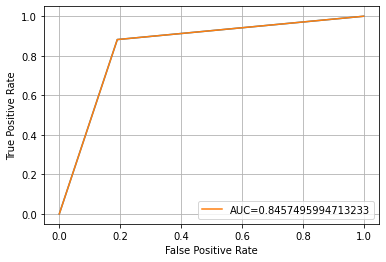

In [36]:
from sklearn import metrics

y_pred = LR.predict(X_valid)
fpr, tpr, _ = metrics.roc_curve(y_valid, y_pred)
auc = metrics.roc_auc_score(y_valid, y_pred)

#create ROC curve
plt.plot(fpr,tpr)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.grid()
plt.savefig('ROC_curve.png')